<a href="https://colab.research.google.com/github/PabloAssCobar/eigenfacePablo/blob/main/eigenfaces_serov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face recognition

*project supervisor: Danil Lykov, MIPT
http://lykov.tech, @danlkv*



We will be solving classification task for images of people. The label of image - the 'true answer' - is the person itself.

First, get familiar with the topic

*  Start here: https://medium.com/data-science-101/face-recognition-opencv-e841dc0006c6
* The list of articles and open-source implementations: https://github.com/xuewengeophysics/Awesome-Face-Recognition And one more: https://github.com/L706077/DNN-Face-Recognition-Papers
* A very usefull article with overview of the topic: https://arxiv.org/pdf/1804.06655.pdf

We will start with EigenFaces and then proceed to FaceNet. 

* EigenFaces: http://openimaj.org/tutorial/eigenfaces.html

* About the FaceNet: https://medium.freecodecamp.org/making-your-own-face-recognition-system-29a8e728107c


**Dataset: Labeled Faces in the Wild**

http://vis-www.cs.umass.edu/lfw/

![alt text](http://vis-www.cs.umass.edu/lfw/Six_Face_Panels_sm.jpg)




# Plan
1. Download and read the dataset. Convert to X-matrix y-answers format
2. Get familiar with OpenCV Haar cascade face detector:we will need to find the face on a picture. https://docs.opencv.org/3.3.1/d7/d8b/tutorial_py_face_detection.html
2. Make a simple model using PCA decomposition over the detected faces. Build a PCA Decomposition of the dataset, then take only most representative vectors. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
3. Having the image-to-vector representation build the recognition framework based on k-nn approach. (for a given image find the closest data points)
3. Use the FaceNet article to implement the model. You can check out open-source implementations from links above or this one: https://github.com/yudi09/Pytorch-FaceNet-LFW
![alt text](https://cdn-images-1.medium.com/max/1200/1*MGb0lv45RwKmBYc87tyNzQ.jpeg)

5. How does the model behave if you add a distance between negative and positive frames? 
6. Check out more recent articles, try to implement their ideas on your model


In [1]:

# download the dataset

! curl 'http://vis-www.cs.umass.edu/lfw/lfw.tgz' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -H 'DNT: 1'  -H 'Referer: http://vis-www.cs.umass.edu/lfw/' -H 'Accept-Encoding: gzip, deflate'  --compressed --output lfw.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  42.8M      0  0:00:04  0:00:04 --:--:-- 42.8M


In [2]:
# check the file on fs
! ls

lfw.tgz  sample_data


In [3]:
filename = 'lfw.tgz'
  
# Unzip the downloaded tar, write output of "tar" command to "filelist.txt"
# the output is list of paths to all unzipped files. We can use them to read data. 

! tar xvzf $filename > filelist.txt


In [4]:
import os
import matplotlib.pyplot as plt

dataset_path = 'lfw/'
people = os.listdir(dataset_path)
images_paths = []
for p in people:
  imgp = os.listdir(dataset_path+p)
  
  images_paths.append([dataset_path+p+'/'+im for im in imgp])

lengths = [len(ip) for ip in images_paths]
print("got %i classes and %i images"%(len(lengths),sum(lengths)))

got 5749 classes and 13233 images


In [5]:
images_paths.sort(key=len,reverse=True)
images_paths = images_paths[:6]
[len(ip) for ip in images_paths]

[530, 236, 144, 121, 109, 77]

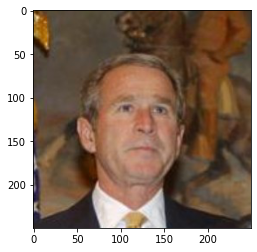

In [6]:
plt.imshow(plt.imread(images_paths[0][1]))


In [7]:
!pip install opencv-python


In [ ]:
import os
os.chdir('/content') 

!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/Skuldur/facenet-face-recognition.git
  
!cp /content/facenet-face-recognition/fr_utils.py /usr/local/lib/python3.6/dist-packages/
!cp /content/facenet-face-recognition/inception_blocks_v2.py /usr/local/lib/python3.6/dist-packages/
!cp -R /content/facenet-face-recognition/weights /usr/local/lib/python3.6/dist-packages/

Cloning into 'opencv'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 248890 (delta 0), reused 0 (delta 0), pack-reused 248886
Receiving objects: 100% (248890/248890), 455.42 MiB | 15.14 MiB/s, done.
Resolving deltas: 100% (173602/173602), done.
Checking out files: 100% (5753/5753), done.
Cloning into 'facenet-face-recognition'...
remote: Enumerating objects: 276, done.
remote: Total 276 (delta 0), reused 0 (delta 0), pack-reused 276
Receiving objects: 100% (276/276), 29.04 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
import numpy  as np
import cv2 as cv
from matplotlib import pyplot as plt


In [ ]:
def detect_eyes(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_sorted_by_size = sorted(eyes, key=lambda x: -x[2])
    largest_eyes = eyes_sorted_by_size[:2]
    # sort by x position
    largest_eyes.sort(key=lambda x: x[0])
    # offset by face start
    return list(map(lambda eye: [face[0] + eye[0], face[1] + eye[1], eye[2], eye[3]], largest_eyes))

In [ ]:
face_cascade = cv.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_eye.xml')

img = cv.imread('/content/facenet-face-recognition/images/skuli.jpg')
img.shape

(584, 584, 3)

In [ ]:
def detectface(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20));
    
    if (len(faces) == 0):
        return None, None
    

    (x, y, w, h) = faces[0]

    return gray[y:y+w, x:x+h], faces[0]
face_recognizer = cv.face.LBPHFaceRecognizer_create()

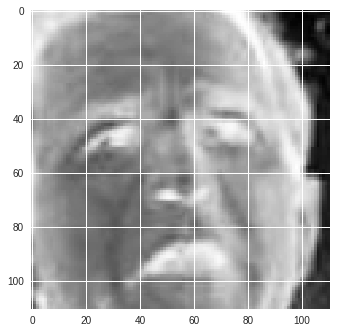

In [ ]:
os.chdir('/content')

#detected_images=list()
def face_detection(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20))
  for (x,y,w,h) in faces:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    face_only = gray[y:y+h, x:x+w]
    coordinates = [x,y,w,h]
    lst = list()
    lst = (face_only,coordinates)
    return lst
        
def face_detection_by_path(path):
  img = cv.imread(path)
  ret = list()
  ret = face_detection(img)
  return ret
  
plt.imshow(face_detection(plt.imread(images_paths[0][1]))[0])
X = list()


In [ ]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Predicting people's names on the test set")

t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


done in 54.938s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.059s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.95      0.67      0.78        27
    George W Bush       0.84      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.83      0.90        36

        micro avg       0.86      0.86      0.86       322
        macro avg       0.90      0.75      0.80       322
     weighted avg       0.87      0.86      0.86       322

[[  7

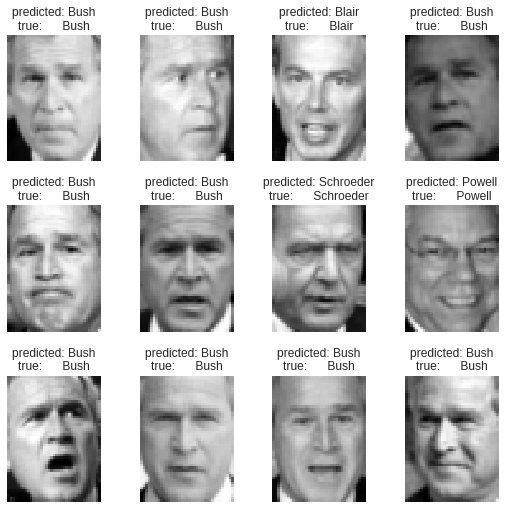

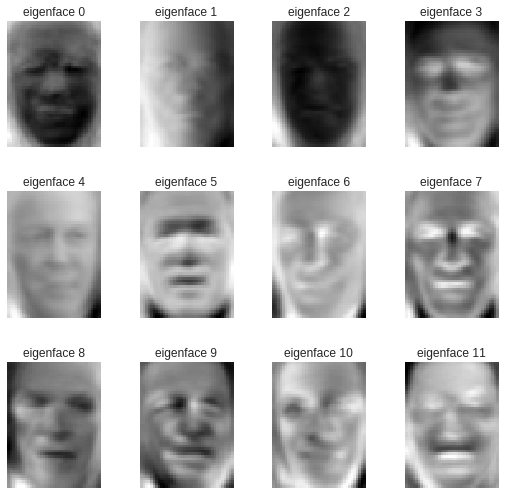

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [ ]:
clf.predict(X_train_pca[0:3])

array([3, 1, 2])